In [1]:
from confitti import ConicFitResult
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sns.set_context("notebook", font_scale=1.2)

## Read in results from prior notebooks

We read the conic-section fits to proplyd arcs from YAML files, which we saved in the previous notebooks: demo03 and demo04. This requires that those notebooks must have been run first. 

In [3]:
arcfits = {
    _id: ConicFitResult.read(f"demo{_id:02d}-fit-result.yaml")
    for _id in [3, 4]
}

/Users/will/Dropbox/confitti/src/confitti/confitti.py:143: RuntimeWarning: divide by zero encountered in divide
  self.r0


In [4]:
arcfits

{3: ConicFitResult({'__lnsigma': -0.417897803684002, 'eccentricity': 1.070798193388295, 'r0': 7.638068634128533, 'theta0': 162.545318007371, 'x0': -0.19006696010244425, 'y0': -1.4903420349819423}),
 4: ConicFitResult({'eccentricity': 1.0, 'r0': 17.288407072422736, 'theta0': 161.254672152365, 'x0': 5.761920739590889, 'y0': -1.2495512045284374})}

## Structure of a ConicFitResult object

The objects that we read from the save files are `confitti.ConicFitResult` objects, which currently contain 3 properties. 

The `.params` property is a dict that holds the best-fit parameters of the conic-section model. For instance, for first proplyd (from demo03):

In [5]:
arcfits[3].params

{'__lnsigma': -0.417897803684002,
 'eccentricity': 1.070798193388295,
 'r0': 7.638068634128533,
 'theta0': 162.545318007371,
 'x0': -0.19006696010244425,
 'y0': -1.4903420349819423}

The `.uparams` property is a dict that holds the 1-sigma uncertainties in the parameters of the conic-section model. For instance, for the second proplyd (from demo04):

In [6]:
arcfits[4].uparams

{'eccentricity': 0.0,
 'r0': 0.6792573217152429,
 'theta0': 2.7528102487901953,
 'x0': 0.8183323226200439,
 'y0': 1.6170640857688103}

Note that this looks different because I saved the results of the original LM fit, rather than the MCMC exploration (just to check that either will work). Hence, there is no `__lnsigma` parameter, which is the MCMC estimate in the scatter of the data points. Also, this is for the parabola fit, instead of the general conic section, so eccentricity is fixed at 1 and the uncertainty in eccentricity is zero. 

The `.xy` property is a `confitti.XYconic` object that can be used for plotting the best-fit curve (see next section):

In [7]:
arcfits[3].xy

Conic(x0=-0.19006696010244425, y0=-1.4903420349819423, r0=7.638068634128533, theta0=162.545318007371, eccentricity=1.070798193388295)

Currently we do not include the original data points or any additional details of the fit, but these could be added if needed. 

## Plot multiple results on the same figure

These proplyds come from different images and their pixel coordinate origins are completely different, so it doesn't really make any sense to plot them together. But we will pretend that it does, just to illustrate the mechanism. 

First, we define a helper function to plot the +/- 1-sigma uncertainty cones so we can look for intersections. 

In [8]:
def plot_theta_range(fitresult, size, ax, color, alpha=0.2):
    """Plot the cone of uncertainty of the axis orientation of a ConicFitResult"""
    # Find th0 +/- dth0
    th1 = fitresult.params["theta0"] - fitresult.uparams["theta0"]
    th2 = fitresult.params["theta0"] + fitresult.uparams["theta0"]
    # Precalculate trig functions
    cth1 = np.cos(np.deg2rad(th1))
    cth2 = np.cos(np.deg2rad(th2))
    sth1 = np.sin(np.deg2rad(th1))
    sth2 = np.sin(np.deg2rad(th2))
    # Cartesian coordinates of endpints of the two boundary lines
    xx1 = fitresult.params["x0"] - size * cth1, fitresult.params["x0"] + size * cth1
    xx2 = fitresult.params["x0"] - size * cth2, fitresult.params["x0"] + size * cth2
    yy1 = fitresult.params["y0"] - size * sth1, fitresult.params["y0"] + size * sth1
    yy2 = fitresult.params["y0"] - size * sth2, fitresult.params["y0"] + size * sth2
    # The easy part is plotting the +/- sigma boundaries
    ax.plot(xx1, yy1, color=color, alpha=alpha)
    ax.plot(xx2, yy2, color=color, alpha=alpha)
    # The hard part is coloring in between them. 
    # We need to interpolate both boundaries onto a common grid,
    # either in x or y, depending on the orientation of the axis. 
    # And we need to make sure that the second argument to np.interp is in increasing order
    # Amazingly, this worked (although, the quasi-vertical case remains untested)
    if np.abs(cth1) > np.abs(sth1):
        # quasi-horizontal case
        if xx1[1] < xx1[0]:
            # Reverse order to make sure xx1 is increasing
            xx1 = xx1[::-1]
            xx2 = xx2[::-1]
            yy1 = yy1[::-1]
            yy2 = yy2[::-1]
        x = np.linspace(*xx1)
        y1 = np.interp(x, xx1, yy1)
        y2 = np.interp(x, xx2, yy2)
        ax.fill_between(x, y1, y2, color=color, alpha=alpha)
    else:
        # quasi-vertical case
        if yy1[1] < yy1[0]:
            # Reverse order to make sure yy1 is increasing
            xx1 = xx1[::-1]
            xx2 = xx2[::-1]
            yy1 = yy1[::-1]
            yy2 = yy2[::-1]
        y = np.linspace(*yy1)
        x1 = np.interp(y, yy1, xx1)
        x2 = np.interp(y, yy2, xx2)
        ax.fill_between_x(y, x1, x2, color=color, alpha=alpha)

Then we plot the curves. Note that in this example, there is a slight overlap in the uncertainty cones (which is fictitious because the two propyds are not really in the same place)

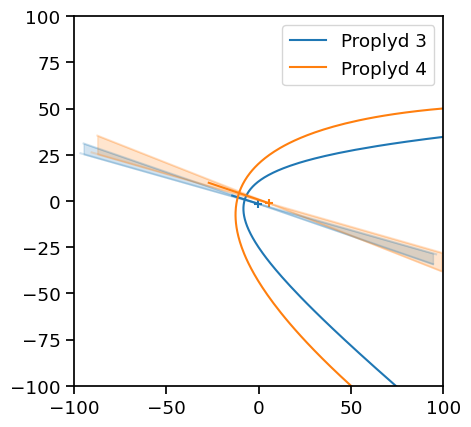

In [9]:
fig, ax = plt.subplots()
size = 100
for label, arc in arcfits.items():
    curve, = ax.plot(arc.xy.x_pts, arc.xy.y_pts, label=f"Proplyd {label}")
    c = curve.get_color()
    ax.scatter(arc.xy.x0, arc.xy.y0, marker="+", color=c)
    ax.plot([arc.xy.x0, arc.xy.x_mirror], [arc.xy.y0, arc.xy.y_mirror], color=c)
    plot_theta_range(arc, size, ax, color=c)
ax.legend()
ax.set(xlim=[-size, size], ylim=[-size, size])
ax.set_aspect("equal")
...;